# Exam project of group 26
### Group members:
- Baltazar Dydensborg
- Johan Kielgast Ladelund
- Laura Weile
- Simon Juul Hansen

### Research Question:
???

### All of the dependency imports

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import datetime
from tqdm import tqdm
import warnings

# Elpriser fra Nordpool

In [ ]:
def getNordpoolData():
    # Get the json data from Nordpool
    url = 'https://www.nordpoolgroup.com/api/downloads/4675'
    el_res = requests.get(url)
    el_json = el_res.json()

    # Selects the urls for the hourly elspot prices in DKK
    hourly = [i for i in el_json['Files'] if i['Resolution'] == 'Hourly']
    elspot = [i for i in hourly if i['Categories'] == ['Elspot Prices']]
    elspot = [i for i in elspot if i['Name'].endswith('DKK')]
    elspot_url = ['https://www.nordpoolgroup.com'+i['Url'] for i in elspot]

    # Create a dictonary with all of the data for each year and put it into a DataFrame
    d = {}
    for i in range(len(elspot_url)):
        d[f'DF_{2013+i}'] = pd.read_html(elspot_url[i])[0].droplevel(level = 0, axis = 1).droplevel(level = 0, axis = 1)

    # Concat the DataFrames into one DF
    df_concat = pd.concat(d)

    # Structure the DataFrame
    df_new = df_concat[['Unnamed: 0_level_2', 'Hours', 'SYS','DK1','DK2']].droplevel(level = 0).reset_index(drop = True)
    df_new[df_new.columns[2:]] = df_new[df_new.columns[2:]]/100
    df_new = df_new.rename(columns = {'Unnamed: 0_level_2': 'date'})

    # Add datetime columns
    df_new['date'] = pd.to_datetime(df_new['date'])
    df_new['Hours'] = df_new['Hours'].str[5:]
    df_new['Hours'] = pd.to_datetime(df_new['Hours'], format = '%H').dt.hour

    return df_new

In [ ]:
df = getNordpoolData()

In [382]:
df['date'][4000:]

4000    2013-06-16
4001    2013-06-16
4002    2013-06-16
4003    2013-06-16
4004    2013-06-16
           ...    
75507   2021-12-08
75508   2021-12-08
75509   2021-12-08
75510   2021-12-08
75511   2021-12-08
Name: date, Length: 71512, dtype: datetime64[ns]

In [ ]:
df = pd.read_html(elspot_url[0])[0].droplevel(level = 0, axis = 1).droplevel(level = 0, axis = 1)
df[df.columns[2:]] = df[df.columns[2:]]/100

In [ ]:
d = {}
for i in range(len(elspot_url)):
    d[f'DF_{2013+i}'] = pd.read_html(elspot_url[i])[0].droplevel(level = 0, axis = 1).droplevel(level = 0, axis = 1)

In [ ]:
df_concat = pd.concat(d)

In [ ]:
df_new = df_concat[['Unnamed: 0_level_2', 'Hours', 'SYS','DK1','DK2']].droplevel(level = 0).reset_index(drop = True)
df_new[df_new.columns[2:]] = df_new[df_new.columns[2:]]/100
df_new = df_new.rename(columns = {'Unnamed: 0_level_2': 'date'})
df_new['date'] = pd.to_datetime(df_new['date'])
df_new['Hours'] = df_new['Hours'].str[5:]
df_new['Hours'] = pd.to_datetime(df_new['Hours'], format = '%H').dt.hour

In [ ]:
df_new

# Vejr data fra DMI API

In [2]:
# Constants

metObsAPIKey = 'c4503ba1-28d4-45c5-850a-974e98bbb3e0'
climateDataAPIKEy = 'ac27b332-bde2-4138-a53e-f0ca82cf3667'
stationId = 6183

dmi_url= lambda API_KEY: f'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items?limit=300000&stationId=06184&parameterId=temp_dry&bbox=7,54,16,58&datetime=2015-01-01T00:00:00Z/2021-08-01T00:00:00Z&api-key={API_KEY}'
dmi_url_id= lambda API_KEY, id: f'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items?limit=300000&stationId=06184&parameterId={id}&bbox=7,54,16,58&datetime=2015-01-01T00:00:00Z/2021-08-01T00:00:00Z&api-key={API_KEY}'
dmi_url_allID= lambda API_KEY: f'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items?limit=300000&stationId=06184&bbox=7,54,16,58&datetime=2015-01-01T00:00:00Z/2021-08-01T00:00:00Z&api-key={API_KEY}'


In [3]:
def metObsData(stat, start_date, end_date, stationId = '06183', apiKey = metObsAPIKey):
    """
    Function that takes a parameter ID and searches for all observations from DMI
    for the given dates, where the date format is given as 'YYYY-MM-DD'
    """

    # Define constants to be used in the function
    url= lambda API_KEY, id, startDate, endDate, stationId: f'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items?limit=300000&stationId={stationId}&parameterId={id}&bbox=7,54,16,58&datetime={startDate}T00:00:00Z/{endDate}T00:00:00Z&api-key={API_KEY}'
    local_counter = 1
    ErrorCounter = 0
    stationCounter = 0
    stationList = ['06184', '06186', '06187', '06188']

    while True:
        try:
            temp_url = url(apiKey, stat, start_date, end_date, stationId)
            ErrorCounter += 1

            json_dmi = requests.get(temp_url).json()
            prop = [item['properties'] for item in json_dmi['features']]
            temp_df = pd.DataFrame(prop)
            
            temp_df['observed'].drop_duplicates(inplace = True)
            temp_df.index = pd.to_datetime(temp_df['observed'])
            temp_df = temp_df.tz_convert('CET')

            if temp_df.index[-1].date() != datetime.date.fromisoformat(start_date):
                            
                if local_counter == 1:
                    df = temp_df.copy()
                    local_counter += 1
                elif local_counter > 1:
                    df = pd.concat([df,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in IF")

                end_date = temp_df.index[-1].date().strftime("%Y-%m-%d")
                continue
            else:
                if local_counter == 1:
                    df = temp_df
                elif local_counter > 1:
                    df = pd.concat([df,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in ELSE")

                break
            


        except KeyError as e:

            try:
                stationId = stationList[stationCounter]
                stationCounter += 1
                continue
            except IndexError as i:
                if ErrorCounter == 1:
                    warnings.warn(f"The requested stat {stat} isn't available for any default stations")
                else:
                    warnings.warn(f"The requested stat {stat} isn't available for any default stations for the daterange: {start_date} - {end_date}")
                return None
        
    return df

        
    

In [4]:
def climateData(stat, start_date, end_date, stationId = '06184',apiKey = climateDataAPIKEy):
    """
    Function that takes a parameter ID and searches for all observations from DMI
    for the given dates, where the date format is given as 'YYYY-MM-DD'
    """

    # Define constants to be used in the function
    url= lambda API_KEY, id, startDate, endDate, stationId: f'https://dmigw.govcloud.dk/v2/climateData/collections/stationValue/items?timeResolution=hour&limit=300000&stationId={stationId}&parameterId={id}&datetime={startDate}T00:00:00Z/{endDate}T00:00:00Z&api-key={API_KEY}'
    local_counter = 1
    ErrorCounter = 0
    stationCounter = 0
    stationList = ['06181', '06186', '06187', '06188']

    while True:
        try:
            temp_url = url(apiKey, stat, start_date, end_date, stationId)
            ErrorCounter += 1

            json_dmi = requests.get(temp_url).json()
            prop = [item['properties'] for item in json_dmi['features']]
            temp_df = pd.DataFrame(prop)
            
            temp_df['to'].drop_duplicates(inplace = True)
            temp_df.index = pd.to_datetime(temp_df['to'])
            #temp_df = temp_df.tz_convert('CET')

            if temp_df.index[-1].date() != datetime.date.fromisoformat(start_date):
                            
                if local_counter == 1:
                    df = temp_df.copy()
                    local_counter += 1
                elif local_counter > 1:
                    df = pd.concat([df,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in IF")

                end_date = temp_df.index[-1].date().strftime("%Y-%m-%d")
                warnings.warn('Loop loop date wrong')
                continue
            else:
                if local_counter == 1:
                    df = temp_df
                elif local_counter > 1:
                    df = pd.concat([df,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in ELSE")

                break
            


        except KeyError as e:

            try:
                stationId = stationList[stationCounter]
                stationCounter += 1
                warnings.warn('Loop loop station wrong')
                continue
            except IndexError as i:
                if ErrorCounter == 1:
                    warnings.warn(f"The requested stat {stat} isn't available for any default stations")
                else:
                    warnings.warn(f"The requested stat {stat} isn't available for any default stations for the daterange: {start_date} - {end_date}")
                return None
        
    return df


In [210]:
def TransformMetObsData(df):
    df = df
    df['hour'] = df.index.hour
    df['date'] = df.index.date
    df = df.drop_duplicates(['parameterId', 'date','hour'])\
            .drop(['created', 'stationId'], axis = 1)\
            .sort_values(by = ['date', 'hour'], ascending = [False, False])\
            .copy()
    
    df_new = df.groupby(['parameterId', 'date', 'hour'])['value'].mean()\
            .unstack(level = 0)\
            .reset_index().rename(columns={df.index.name:None})

    return df_new
    

In [211]:
def transformClimateData(df):
    df = df
    df = df.tz_convert('CET')
    df['hour'] = df.index.hour
    df['date'] = df.index.date
    df = df.drop_duplicates(['parameterId', 'date','hour'])\
            .drop(['calculatedAt', 'created', 'from', 'qcStatus', 'timeResolution', 'validity'], axis = 1)\
            .sort_values(by = ['date', 'hour'], ascending = [False, False])\
            .copy()
    
    df_new = df.groupby(['parameterId', 'date', 'hour'])['value'].mean()\
            .unstack(level = 0)\
            .reset_index().rename(columns={df.index.name:None})

    return df_new

In [ ]:
list_of_stats=['wind_min', 'wind_max', 'visibility', 'cloud_cover', 'cloud_height', 'temp_dry', 'wind_speed', 'wind_dir', 'pressure', 'humidity']

dict_df = dict()
for stat in tqdm(list_of_stats):
    dict_df[stat] = metObsData(stat, '2015-01-01', '2021-08-01')

new_df_met = pd.concat(dict_df.values())
transform_df_met = TransformMetObsData(new_df_met)


In [ ]:
list_of_stats_climate =['bright_sunshine', 'mean_radiation', 'mean_pressure', 'mean_wind_dir', 'acc_precip', 'temp_grass', 'mean_relative_hum', 'mean_temp']

dict_df_climate = dict()
for stat in tqdm(list_of_stats_climate):
    dict_df_climate[stat] = climateData(stat, '2015-01-01', '2021-08-01')

new_df_climate = pd.concat(dict_df_climate.values())
transform_df_climate = transformClimateData(new_df_climate)

In [106]:
def metObsPipeline(stats, start_date, end_date):
    dict_df = dict()
    for stat in tqdm(stats):
        dict_df[stat] = metObsData(stat, start_date, end_date)

    new_df_met = pd.concat(dict_df.values())
    transform_df_met = TransformMetObsData(new_df_met)
    return transform_df_met

In [105]:
def climatePipeline(stats, start_date, end_date):
    dict_df = dict()
    for stat in tqdm(stats):
        dict_df[stat] = climateData(stat, start_date, end_date)

    new_df_climate = pd.concat(dict_df.values())
    transform_df_climate = transformClimateData(new_df_climate)
    return transform_df_climate

In [143]:
def merger(df_met, df_climate, start_date, end_date):
    index1 = pd.date_range(start=start_date, end=end_date, freq = 'H').to_pydatetime().tolist()
    dfindex = pd.DataFrame(index = index1)
    dfindex['date'] = dfindex.index.date
    dfindex['hour'] = dfindex.index.hour
    merge_df = dfindex.reset_index().merge(df_met, how="left", on = ['date', 'hour'])
    merge_df = merge_df.merge(df_climate, how = 'left', on = ['date', 'hour'])
    merge_df = merge_df.set_index('index').sort_index()
    return merge_df

In [111]:
def total_pipeline(met_stats, climate_stats, start_date, end_date):
    print('Running metObs pipeline')
    df_met = metObsPipeline(met_stats, start_date, end_date)
    print('Running Climate data pipeline')
    df_climate = climatePipeline(climate_stats, start_date, end_date)
    print('Merging the climate and metObs data together')
    df_total = merger(df_met, df_climate, start_date, end_date)
    return df_total

In [ ]:
for i in merge_df.columns:
    num_na = len(merge_df[i]) - len(merge_df[i].dropna())
    print(f"{i}: {num_na}")

In [ ]:
merge_df[pd.isna(merge_df['mean_temp'])].head(10)

In [368]:
merge_df[merge_df.columns[3:]].columns

Index(['cloud_height', 'humidity', 'pressure', 'temp_dry', 'visibility',
       'wind_dir', 'wind_max', 'wind_speed', 'acc_precip', 'bright_sunshine',
       'mean_pressure', 'mean_radiation', 'mean_relative_hum', 'mean_temp',
       'mean_wind_dir', 'temp_grass'],
      dtype='object', name='parameterId')

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

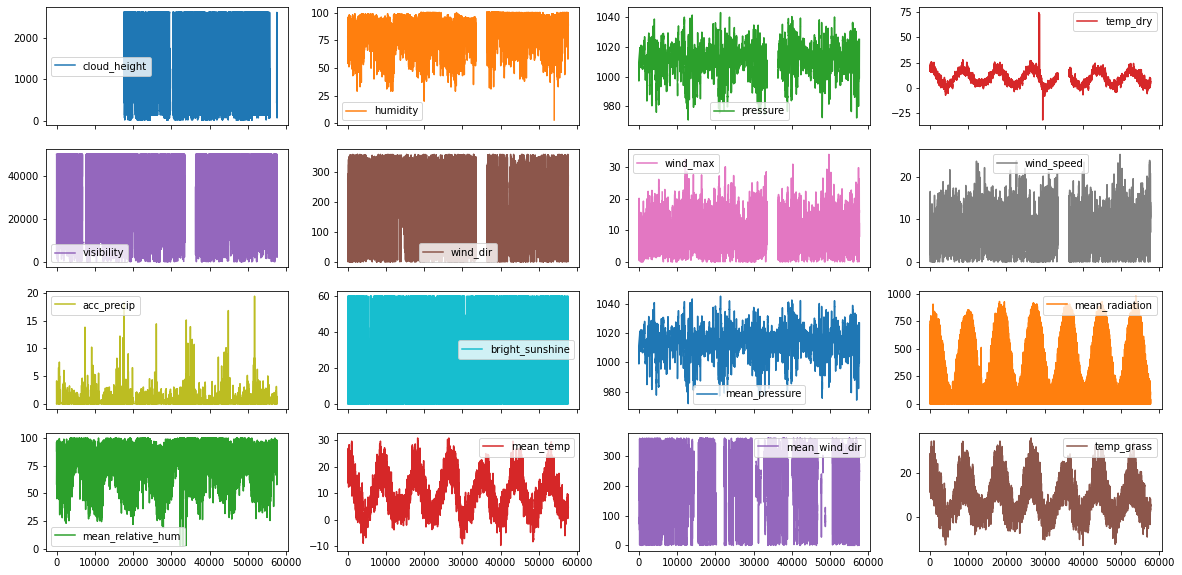

In [369]:
#len(merge_df[merge_df.columns[3:]].columns)

merge_df[merge_df.columns[3:]].plot(subplots=True, layout=(4,4), figsize = (20,10), sharex=True)

In [212]:
metObs_list = [ 'wind_max', 'visib_mean_last10min', 'temp_soil_max_past1h', 'cloud_height', 'temp_mean_past1h', 'wind_speed_past1h', 'wind_dir_past1h', 'pressure', 'humidity_past1h']

climate_list = ['bright_sunshine', 'mean_radiation', 'mean_pressure', 'acc_precip', 'temp_grass', 'mean_relative_hum', 'mean_temp']

df = total_pipeline(metObs_list, climate_list, '2015-01-01', '2021-08-01')


  0%|          | 0/9 [00:00<?, ?it/s]

Running metObs pipeline


  0%|          | 0/7 [00:00<?, ?it/s]

Running Climate data pipeline


<ipython-input-4-e4323209ab18>:57: UserWarning: Loop loop station wrong
  warnings.warn('Loop loop station wrong')
 29%|██▊       | 2/7 [00:19<00:47,  9.55s/it]<ipython-input-4-e4323209ab18>:38: UserWarning: Loop loop date wrong
  warnings.warn('Loop loop date wrong')
100%|██████████| 7/7 [01:08<00:00,  9.79s/it]


Merging the climate and metObs data together


array([[<AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>,
        <AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>],
       [<AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>,
        <AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>],
       [<AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>,
        <AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>],
       [<AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>,
        <AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>]],
      dtype=object)

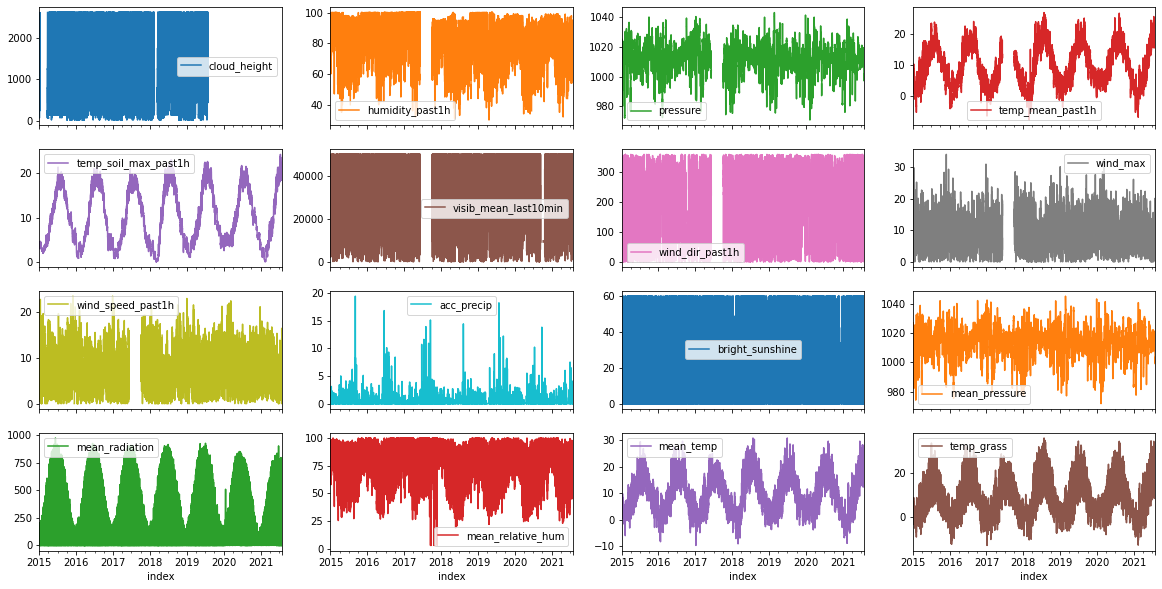

In [215]:
df[df.columns[2:]].plot(subplots=True, layout=(4,4), figsize = (20,10), sharex=True);

In [216]:
df

,date,hour,cloud_height,humidity_past1h,pressure,temp_mean_past1h,temp_soil_max_past1h,visib_mean_last10min,wind_dir_past1h,wind_max,wind_speed_past1h,acc_precip,bright_sunshine,mean_pressure,mean_radiation,mean_relative_hum,mean_temp,temp_grass
index,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,2015-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00,2015-01-01,1,450.0,90.0,1024.9,4.9,3.5,11000.0,285.0,12.1,11.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 02:00:00,2015-01-01,2,450.0,89.0,1024.8,4.7,3.5,14700.0,288.0,9.9,11.8,0.0,0.0,1026.7,0.0,86.5,4.5,3.4
2015-01-01 03:00:00,2015-01-01,3,800.0,88.0,1024.7,4.8,3.5,12100.0,279.0,8.5,8.8,0.0,0.0,1026.5,0.0,85.7,4.6,3.5
2015-01-01 04:00:00,2015-01-01,4,450.0,89.0,1023.9,5.0,3.6,16900.0,272.0,7.9,7.7,0.0,0.0,1026.1,0.0,87.5,4.4,3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-31 20:00:00,2021-07-31,20,NaN,85.0,997.9,16.9,19.7,50000.0,276.0,13.4,7.3,0.2,4.0,998.9,56.0,96.0,15.4,15.8
2021-07-31 21:00:00,2021-07-31,21,NaN,83.0,998.6,17.0,19.6,50000.0,275.0,14.8,11.3,0.0,33.5,999.3,45.0,95.0,15.6,15.2
2021-07-31 22:00:00,2021-07-31,22,NaN,86.0,999.3,17.4,19.6,50000.0,268.0,13.4,11.1,4.1,0.0,1000.1,2.0,96.2,15.2,14.7
